# ResNet50 - Data Cleaning

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from glob import glob
import tensorflow as tf
import pandas as pd
import warnings
import os
import PIL
import math
import cv2
from tqdm import tqdm
import shutil

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical, plot_model
import random as rn
from tqdm import tqdm
from random import shuffle
from PIL import Image
from IPython.display import SVG
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Activation, Dropout, Flatten, Dense

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

## Base Setup

In [240]:
path = "C:/Users/Asus/Data Science Project/Dataset/"
os.chdir(path)

## ResNet 50 Setup - Classes and Model

In [241]:
#Create ResNet50 classes dict
ResNetClasses = "C:/Users/Asus/Data Science Project/ResNetClasses.txt"
file1 = open(ResNetClasses, "r")

resnet_classes_dictionary = {}

for line in file1:
    line.replace(' ','')
    key, value = line.split(':')
    key = key.replace(':','').replace(" ", "")
    value = value.replace("'", "").replace(",\n",'').replace(" ", "")

    resnet_classes_dictionary[key] = value

In [242]:
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

## Functions Declarations

#### Subfolder functions

In [243]:
def search_subfolders(dataset_path):
  subfolder_list = path_to_subfolder(os.listdir(),dataset_path)
  return subfolder_list

In [244]:
def path_to_subfolder(sub_list,dataset_path):
  for index, breed in enumerate(sub_list):
    sub_list[index] = str(os.path.join(dataset_path,breed))
  return sub_list

In [245]:
def files_in_folder(subfolders_list):
    files_in_folder = []
    for sub in subfolders_list:
        if os.path.isdir(sub):
            files_in_folder.append(len([item for item in os.listdir(sub)]))
    return files_in_folder

#### Plot's functions

In [246]:
def before_cleaning_eda(subfolders_list):
    total_dict = {"Folder Name":[],"Number Of Images":[]}
    
    for sub in subfolders_list:
        if os.path.isdir(sub):
            total_dict["Folder Name"].append(sub.rsplit("/",maxsplit=1)[1])
            total_dict["Number Of Images"].append(len([item for item in os.listdir(sub)]))

    df_total = pd.DataFrame({ key:pd.Series(value) for key, value in total_dict.items() })
    return df_total.plot.barh(xlabel='Breed', ylabel='Images Data', title='Files Before Data Cleaning',x='Folder Name',rot=0,figsize=(8, 8),fontsize=16)

In [247]:
def after_cleaning_eda(subfolders_list,ax):
    total_dict = {"Folder Name":[],"Number Of Images":[]}
    
    for sub in subfolders_list:
        if os.path.isdir(sub):
            total_dict["Folder Name"].append(sub.rsplit("/",maxsplit=1)[1])
            total_dict["Number Of Images"].append(len([item for item in os.listdir(sub)]))

    df_total = pd.DataFrame({ key:pd.Series(value) for key, value in total_dict.items() })
    #df_total.plot.barh(xlabel='Breed', ylabel='Images Data', title='Files After Data Cleaning',x='Folder Name',rot=0,figsize=(8, 8),fontsize=16)
    return df_total.plot.barh(xlabel='Breed', ylabel='Images Data', title='Files After Data Cleaning',x='Folder Name',rot=0,figsize=(8, 8),fontsize=16)

In [248]:
def before_after_df(col_names,data_before_cleaning,data_after_cleaning):
    total_dict = {"Breed Name":[],"Before Data Cleaning":[],"After Data Cleaning":[]}

    for name in col_names:
        total_dict["Breed Name"].append(name)

    for num in data_before_cleaning:
        total_dict["Before Data Cleaning"].append(num)

    for num in data_after_cleaning:
        total_dict["After Data Cleaning"].append(num)

    df_total = pd.DataFrame({ key:pd.Series(value) for key, value in total_dict.items() })
    return df_total

In [291]:
def sum_list(list_values):
    return sum(list_values)

#### ResNet50 and Tensorflow functions

In [249]:
#from keras.preprocessing import image                  
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [250]:
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [251]:
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [252]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151),prediction) 

#### Data cleaning - files modify functions

In [253]:
def data_cleaning(rmv_list,img_list):
  counter = 0
  for i in rmv_list:
    try:
      img_list.remove(i)
      counter += 1
    except:
      print(i)
      continue

  print(f"AFTER CLEANING:::  deleted {counter} non-dog images")
  print(f"AFTER CLEANING:::  total files in the directory {len(img_list)}")

In [254]:
def img_delete(img_list,breed_type):
    counter = 0
    for img in img_list:
          try:
            os.remove(img)
            counter+=1
          except:
            print("There was an error deleting the file: %"%(img))
    print(f"{breed_type} - Total images deleted: {counter}")

In [255]:
def trash_image(image_list,breed_type,trash_sub_path):
    counter = 0
    for path in image_list:
        change_file = path.rsplit("\\",maxsplit=1)[0]
        counter+=1
        new_name = f'trash_image_{breed_type}_{counter}.jpg'
        
        local_path = change_file+'/'+new_name
        trash_path = trash_sub_path +'/'+ breed_type + '/' +new_name
        
        os.rename( path ,local_path) 
        shutil.move(local_path , trash_path)
        
        #print(f"new trash_image_{counter} path: {trash_sub_path+'/'+new_name}")

In [256]:
def trash_image_folder(path,subfolder_list):
    directory = "Trash images"
    trash_path = os.path.join(path, directory)
    try:
        os.mkdir(trash_path)
        print("Created trash folder")
        
        for sub in subfolder_list:
            folder_name = sub.rsplit("/",maxsplit=1)[1]
            breed_tash_sub = os.path.join(trash_path, folder_name)
            os.mkdir(breed_tash_sub)
        
    except:
        print("Trash folder already created!")
    return trash_path

In [257]:
def clean_folders_data(subfolders_list,df):
    
    trash_folder_path = trash_image_folder(path,subfolders_list)
    
    before_size = 0
    deleted_elem_count = 0
    new_size = 0
    not_dog = 0
    
    for sub in subfolders_list:
        trash_list = []
        breed_type = sub.rsplit("/",maxsplit=1)[1]
        breed_files = [os.path.join(sub, f) for f in os.listdir(sub) if os.path.isfile(os.path.join(sub, f))]
        before_size += len(breed_files)

        count_dog = 0
        not_dog_del = 0
        not_dogs = []
        dog_classes = {}
        print(f"BEFORE CLEANING::: {breed_type} total files in directory: {len(breed_files)}")

        for count, img in enumerate(breed_files):
            img_path = os.path.join
            ans, pred_class  = dog_detector(img)
            if ans == True:
                count_dog += 1
            else:
                if(len(trash_list)<5):
                    trash_list.append(img)
                else:
                    not_dogs.append(img)
                    breed_files.remove(img)
                df.at[int(pred_class), breed_type] = df.at[int(pred_class), breed_type]+1
    
        trash_image(trash_list,breed_type,trash_folder_path)

        print(f"found {count_dog} dogs! --- total not dogs {len(not_dogs)}")
        
        deleted_elem_count += len(not_dogs)

        img_delete(not_dogs,breed_type)

        print(f"AFTER CLEANING::: {breed_type} total files in directory: {len(breed_files)}")
        print("----------------------------------")
        
    print("All Data Cleaned!")
    print(f"Total images deleted: {deleted_elem_count}")
    print(f"Before cleaning total files count: {before_size}")
    print(f"After cleaning total files count: {before_size - deleted_elem_count}")

## Data Cleaning Runing

In [259]:
subfolders_list = []

subfolders_list = search_subfolders(path)
subfolders_list.sort()

for sub in subfolders_list:
    if(sub.rsplit("/",maxsplit=1)[1] == "trash images"):
        subfolders_list.remove(sub)

#### Plot - How many files was for each breed before data cleaning process

In [293]:
data_before_cleaning = files_in_folder(subfolders_list)
before_total = sum_list(data_before_cleaning)
print(before_total)
print(data_before_cleaning)

125980
[4578, 6079, 8968, 6330, 7440, 9191, 9712, 710, 1215, 9631, 1146, 9028, 8997, 8871, 9443, 5580, 9108, 3904, 6049]


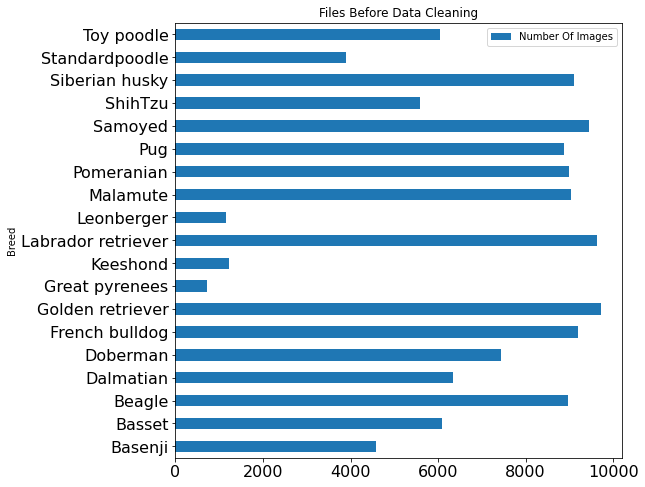

In [275]:
plot = before_cleaning_eda(subfolders_list)
fig = plot.get_figure()
fig.savefig("before_data_cleaning.png",bbox_inches='tight')
fig.savefig("before_data_cleaning_jpg.jpg",bbox_inches='tight')

#### Dataframe - ResNet classes result in the data cleaning process in each breed 

In [262]:
total_df = pd.DataFrame.from_dict(resnet_classes_dictionary.values())
col_names = []

for sub in subfolders_list:
  col_name = sub.rsplit("/",maxsplit=1)[1]
  total_df[col_name] = "" 
  col_names.append(col_name)

df_new = total_df.rename(columns = {0:'ResNet Class'})

for col in df_new.columns:
    if(col!="ResNet Class"):
        df_new[col].values[:] = 0

df_new

,ResNet Class,Basenji,Basset,Beagle,Dalmatian,Doberman,French bulldog,Golden retriever,Great pyrenees,Keeshond,Labrador retriever,Leonberger,Malamute,Pomeranian,Pug,Samoyed,ShihTzu,Siberian husky,Standardpoodle,Toy poodle
0,"tench,Tincatinca",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"goldfish,Carassiusauratus",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"greatwhiteshark,whiteshark,man-eater,man-eatin...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"tigershark,Galeocerdocuvieri",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"hammerhead,hammerheadshark",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,earthstar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,"hen-of-the-woods,henofthewoods,Polyporusfrondo...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,bolete,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,"ear,spike,capitulum",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Clean Data Process

In [263]:
clean_folders_data(subfolders_list,df_new)

Created trash folder
BEFORE CLEANING::: Basenji total files in directory: 5118
found 4043 dogs! --- total not dogs 535
Basenji - Total images deleted: 535
AFTER CLEANING::: Basenji total files in directory: 4583
----------------------------------
BEFORE CLEANING::: Basset total files in directory: 9370
found 2794 dogs! --- total not dogs 3286
Basset - Total images deleted: 3286
AFTER CLEANING::: Basset total files in directory: 6084
----------------------------------
BEFORE CLEANING::: Beagle total files in directory: 11040
found 6901 dogs! --- total not dogs 2067
Beagle - Total images deleted: 2067
AFTER CLEANING::: Beagle total files in directory: 8973
----------------------------------
BEFORE CLEANING::: Dalmatian total files in directory: 8570
found 4095 dogs! --- total not dogs 2235
Dalmatian - Total images deleted: 2235
AFTER CLEANING::: Dalmatian total files in directory: 6335
----------------------------------
BEFORE CLEANING::: Doberman total files in directory: 8879
found 600

#### Plot - How many files was for each breed after data cleaning process

In [292]:
data_after_cleaning = files_in_folder(subfolders_list)
after_total = sum_list(data_after_cleaning)
print(after_total)
print(data_after_cleaning)

125980
[4578, 6079, 8968, 6330, 7440, 9191, 9712, 710, 1215, 9631, 1146, 9028, 8997, 8871, 9443, 5580, 9108, 3904, 6049]


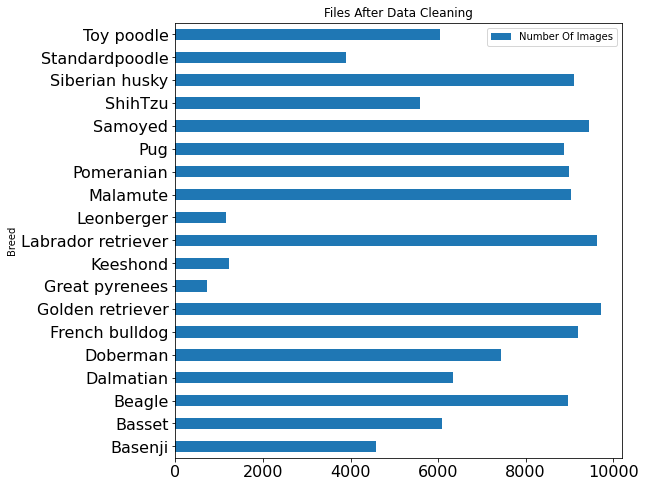

In [273]:
plot = after_cleaning_eda(subfolders_list,ax)
fig = plot.get_figure()
fig.savefig("after_data_cleaning.png",bbox_inches='tight')
fig.savefig("after_data_cleaning_jpg.jpg",bbox_inches='tight')

#### Dataframe - main results after the data cleaning

In [266]:
df_new[(df_new[col_names] > 0).any(axis=1)]

,ResNet Class,Basenji,Basset,Beagle,Dalmatian,Doberman,French bulldog,Golden retriever,Great pyrenees,Keeshond,Labrador retriever,Leonberger,Malamute,Pomeranian,Pug,Samoyed,ShihTzu,Siberian husky,Standardpoodle,Toy poodle
0,"tench,Tincatinca",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"goldfish,Carassiusauratus",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"greatwhiteshark,whiteshark,man-eater,man-eatin...",0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,1,0,0
4,"hammerhead,hammerheadshark",0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5,"electricray,crampfish,numbfish,torpedo",0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,"stinkhorn,carrionfungus",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
995,earthstar,0,0,1,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0
996,"hen-of-the-woods,henofthewoods,Polyporusfrondo...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
998,"ear,spike,capitulum",0,59,2,0,2,3,1,0,0,1,0,3,2,1,1,0,0,0,3


#### Before And After Datafram and Plot

In [290]:
df_baf = before_after_df(col_names,data_before_cleaning,data_after_cleaning)
df_baf

,Breed Name,Before Data Cleaning,After Data Cleaning
0,Basenji,5118,4578
1,Basset,9370,6079
2,Beagle,11040,8968
3,Dalmatian,8570,6330
4,Doberman,8879,7440
5,French bulldog,11039,9191
6,Golden retriever,11032,9712
7,Great pyrenees,861,710
8,Keeshond,1306,1215
9,Labrador retriever,11040,9631


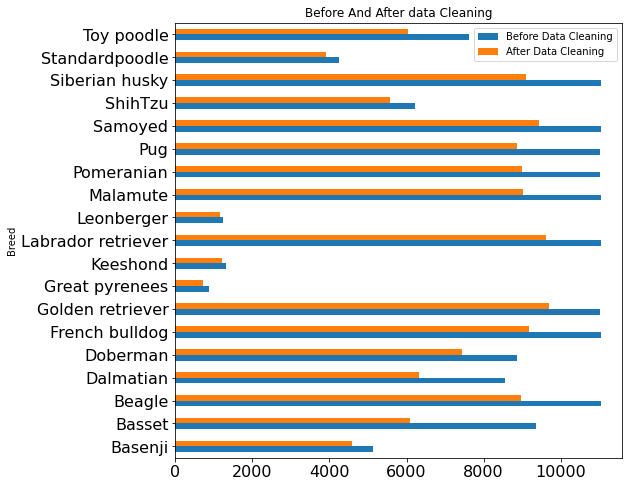

In [274]:
plot = df_baf.plot.barh(xlabel='Breed', ylabel='Images Data', title='Before And After data Cleaning',x='Breed Name',rot=0,figsize=(8, 8),fontsize=16)
fig = plot.get_figure()
fig.savefig("before_and_after.png",bbox_inches='tight')
fig.savefig("before_and_after_jpg.jpg",bbox_inches='tight')

#### Export the final df to csv file

In [271]:
df_new.to_csv('df_after_cleaning_ResNet_classes', sep='\t')

In [270]:
df_baf.to_csv('df_after_cleaning_stats', sep='\t')